### Data Analysis Summary

The dataset used in this project consists of three main files: transactions, customers, and articles. The goal of the analysis was to study:
- Customer behaviour
- Product performance, and
- Age-based product preferences

- using the complete dataset.
##### Dask was used instead of Pandas because of its ability to handle large datasets efficiently through parallel processing.

In [1]:

import dask.dataframe as dd
import matplotlib.pyplot as plt

# just making plots a bit bigger
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
# The path relative to notebook
base_path = "Data"

#### Data Loading and Preparation


In [3]:
# loading transactions data with only the columns we need
trans_cols = ["t_dat", "customer_id", "article_id", "price", "sales_channel_id"]
transactions = dd.read_csv(
    f"{base_path}/transactions_train.csv",
    usecols=trans_cols,
    assume_missing=True,
    dtype={
        "customer_id": "object",
        "article_id": "int64",
        "price": "float64",
        "sales_channel_id": "int8",
    },
)

# loading customers data
cust_cols = ["customer_id", "club_member_status", "fashion_news_frequency", "age"]
customers = dd.read_csv(
    f"{base_path}/customers.csv",
    usecols=cust_cols,
    assume_missing=True,
    dtype={
        "customer_id": "object",
        "club_member_status": "object",
        "fashion_news_frequency": "object",
        "age": "float64",
    },
)

# loading products data
art_cols = [
    "article_id",
    "prod_name",
    "product_type_name",
    "product_group_name",
    "colour_group_name",
    "department_name",
    "index_name",
]
articles = dd.read_csv(
    f"{base_path}/articles.csv",
    usecols=art_cols,
    assume_missing=True,
    dtype={
        "article_id": "int64",
        "prod_name": "object",
        "product_type_name": "object",
        "product_group_name": "object",
        "colour_group_name": "object",
        "department_name": "object",
        "index_name": "object",
    },
)

# quick peek at transactions just to make sure it loaded fine
transactions.head()


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


loading the three main h&m csv files directly with dask so i can use the full dataset.
for each file i only select the columns that are relevant for analytics and set proper data types to avoid issues later while merging.

In [6]:
# converting date column to proper datetime format
transactions["t_dat"] = dd.to_datetime(transactions["t_dat"], errors="coerce")

# removing rows with invalid or zero prices
transactions = transactions[transactions["price"] > 0]

# extracting useful time features
transactions["year"] = transactions["t_dat"].dt.year
transactions["month"] = transactions["t_dat"].dt.month
transactions["day_of_week"] = transactions["t_dat"].dt.day_name()

# quick check to see the new columns
transactions.head()


,t_dat,customer_id,article_id,price,sales_channel_id,year,month,day_of_week
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2018,9,Thursday
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2018,9,Thursday
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,2018,9,Thursday
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,2018,9,Thursday
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,2018,9,Thursday


cleaning the transactions data and preparing time-based features.
converting t_dat to datetime, removing invalid prices, and creating columns for year, month, and day_of_week.
this helps later when analysing seasonal and daily sales trends.

In [7]:
# sometimes when reading csv, dask treats ids as float due to missing values
# making sure both sides have the same type for safe merging
transactions["article_id"] = transactions["article_id"].astype("int64")
articles["article_id"] = articles["article_id"].astype("int64")


tx_cust = transactions.merge(customers, on="customer_id", how="left")
full_data = tx_cust.merge(articles, on="article_id", how="left")


full_data.head()


,t_dat,customer_id,article_id,price,sales_channel_id,year,month,day_of_week,club_member_status,fashion_news_frequency,age,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name
0,2019-05-22,0da40e05f9d400c55750fe37923c354ef1115afac93a1c...,716672003,0.025407,1,2019,5,Wednesday,ACTIVE,Regularly,20.0,Jennifer Top,Vest top,Garment Upper body,Black,Blouse,Ladieswear
1,2019-05-22,0da40e05f9d400c55750fe37923c354ef1115afac93a1c...,619884018,0.042356,1,2019,5,Wednesday,ACTIVE,Regularly,20.0,Trinny,Shorts,Garment Lower body,Dark Blue,Trouser,Ladieswear
2,2019-05-22,0da40e05f9d400c55750fe37923c354ef1115afac93a1c...,656763006,0.025407,1,2019,5,Wednesday,ACTIVE,Regularly,20.0,Kajsa HW,Shorts,Garment Lower body,Black,Shorts,Ladieswear
3,2019-05-22,0e23a4ba937be31e9ea7e5707a2a38d5fd883440f07c3d...,751998002,0.025407,1,2019,5,Wednesday,ACTIVE,NONE,23.0,Melrose,Shirt,Garment Upper body,Light Blue,Blouse,Ladieswear
4,2019-05-22,0e23a4ba937be31e9ea7e5707a2a38d5fd883440f07c3d...,688873007,0.033881,1,2019,5,Wednesday,ACTIVE,NONE,23.0,Gyda!,Blouse,Garment Upper body,Dark Blue,Blouse,Ladieswear


fixing a small datatype mismatch on article_id before merging (float vs int).
this ensures the joins work cleanly without warnings.
after converting both to int64, merging transactions, customers, and articles gives one combined dask dataframe full_data.

In [8]:
# merging transactions with customers so we know who is buying
tx_cust = transactions.merge(customers, on="customer_id", how="left")

# now merging that with articles so we know what they bought
full_data = tx_cust.merge(articles, on="article_id", how="left")

# checking a few rows to confirm merge worked
full_data.head()


,t_dat,customer_id,article_id,price,sales_channel_id,year,month,day_of_week,club_member_status,fashion_news_frequency,age,prod_name,product_type_name,product_group_name,colour_group_name,department_name,index_name
0,2018-09-20,0091c0e943c92167ea78f6ac180636be4098b06c1a066c...,677341001,0.080492,2,2018,9,Thursday,ACTIVE,Regularly,67.0,Stevens quilted coat,Jacket,Garment Upper body,Dark Blue,Outwear,Ladieswear
1,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,678073001,0.024424,2,2018,9,Thursday,ACTIVE,Regularly,34.0,Ronja Dress,Dress,Garment Full body,Black,Basic 1,Divided
2,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,671515001,0.024424,2,2018,9,Thursday,ACTIVE,Regularly,34.0,EDC J CARLOTTA POLO TOP,Polo shirt,Garment Upper body,Black,Campaigns,Ladieswear
3,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,622046002,0.019542,2,2018,9,Thursday,ACTIVE,Regularly,34.0,Lagoon,Blouse,Garment Upper body,Black,Blouse,Ladieswear
4,2018-09-20,00c59bdfaf753688c62cc13f67382dd54275f776a2f6a6...,678073002,0.024424,2,2018,9,Thursday,ACTIVE,Regularly,34.0,Ronja Dress,Dress,Garment Full body,Black,Basic 1,Divided


merging all three datasets using dask to create a complete view of transactions.
each row in full_data now contains purchase details, customer information, and product details.
still keeping it as a dask dataframe (not computed yet) so the notebook doesn’t run out of memory.

### Analytics 1: Customer Behaviour
The first analysis explored customer behaviour using groupby operations on age, club membership status, and sales channel.
- Average spending by age showed that middle-aged customers spent slightly more per transaction.
- Analysis of club membership status revealed that average spending was similar across all categories, with some missing data represented as <NA>.
- The sales channel distribution indicated that approximately 70% of transactions occurred in physical stores and 30% through online channels.

This section used .mean().compute() to calculate average values efficiently across the full dataset, letting Dask process all data in parallel before returning the small aggregated results.


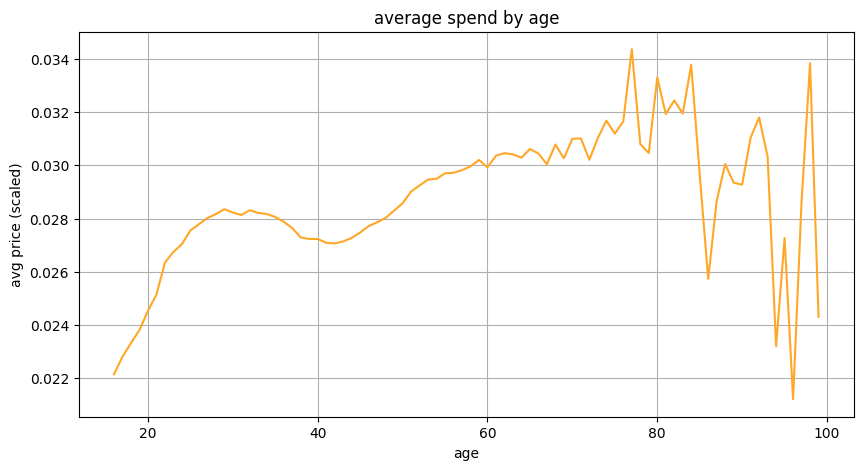

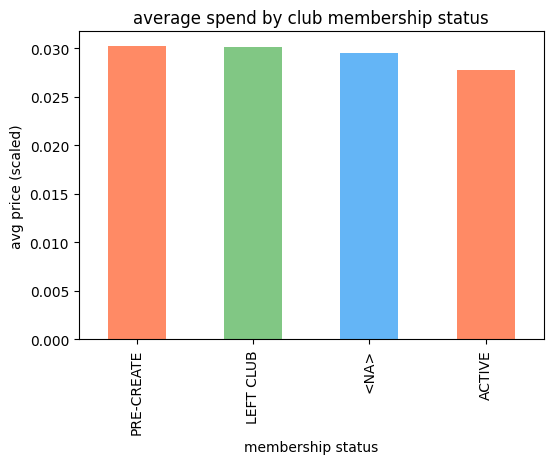

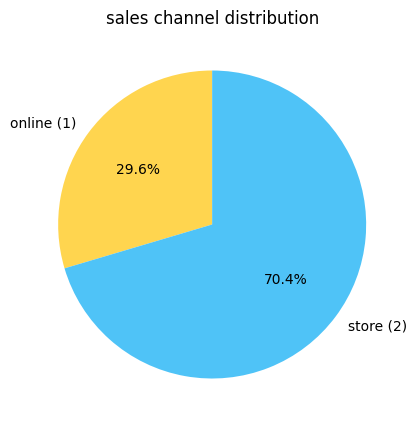

In [9]:
# checking how avg spend changes by age
avg_spend_age = (
    full_data.groupby("age")["price"]
    .mean()
    .compute()
    .sort_index()
)

# plotting avg spend by age
plt.figure(figsize=(10,5))
avg_spend_age.plot(kind="line", color="#FFA726")
plt.title("average spend by age")
plt.xlabel("age")
plt.ylabel("avg price (scaled)")
plt.grid(True)
plt.show()


# checking avg spend based on club membership
club_spend = (
    full_data.groupby("club_member_status")["price"]
    .mean()
    .compute()
    .sort_values(ascending=False)
)

# plotting club member vs non-member
plt.figure(figsize=(6,4))
club_spend.plot(kind="bar", color=["#FF8A65", "#81C784", "#64B5F6"])
plt.title("average spend by club membership status")
plt.xlabel("membership status")
plt.ylabel("avg price (scaled)")
plt.show()


# checking how much was bought online vs store
channel_split = (
    full_data["sales_channel_id"]
    .value_counts()
    .compute()
    .sort_index()
)

# renaming channel ids to make them readable
channel_split.index = ["online (1)", "store (2)"]

# plotting online vs store sales
plt.figure(figsize=(5,5))
channel_split.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=["#FFD54F", "#4FC3F7"])
plt.title("sales channel distribution")
plt.ylabel("")
plt.show()


#### Insights:
**Avg spend by age:**
- Spending slightly rises with age — mid-age and older customers spend a bit more per item.
- Younger customers (<25) spend the least on average.

**Avg spend by club membership:**
- Pre-create and left-club members spend marginally higher than active ones.
- The <NA> bar represents customers with missing membership info — they likely aren’t registered in the loyalty system.

**Sales channel distribution:**
- Majority of purchases (≈70%) come from physical stores (2).
- Online sales (1) make up about 30%, showing stores are still the main channel for H&M.


### Analytics 2: Product and Time Trends
The second analysis focused on identifying top-performing products, departments, and seasonal sales patterns.
Grouping by product type showed that trousers, dresses, and sweaters generated the highest total sales.
- Monthly analysis showed sales peaks in June and September, indicating seasonal buying behaviour.
- Department-level analysis found that the trouser, knitwear, and swimwear departments were the most profitable.


.sum().compute() was used in this step to calculate total scaled sales from the entire dataset. The results provided a clear overview of which products and time periods contributed most to H&M’s overall revenue.


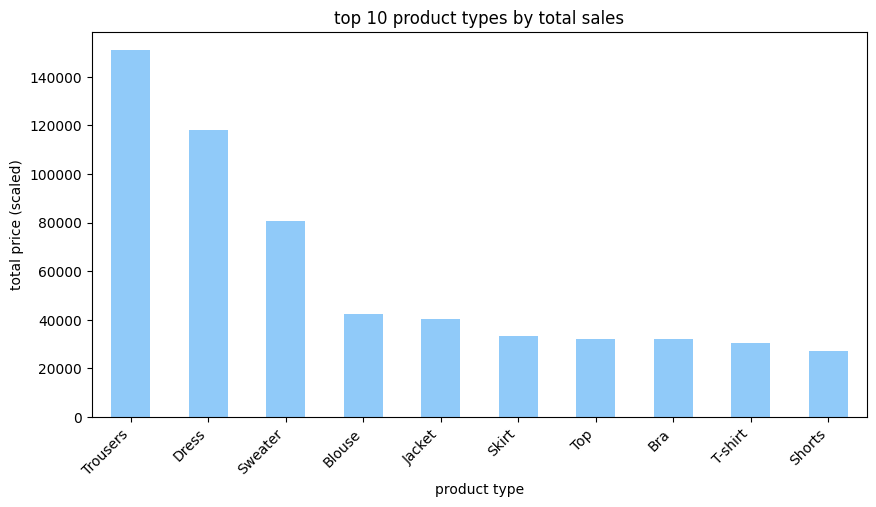

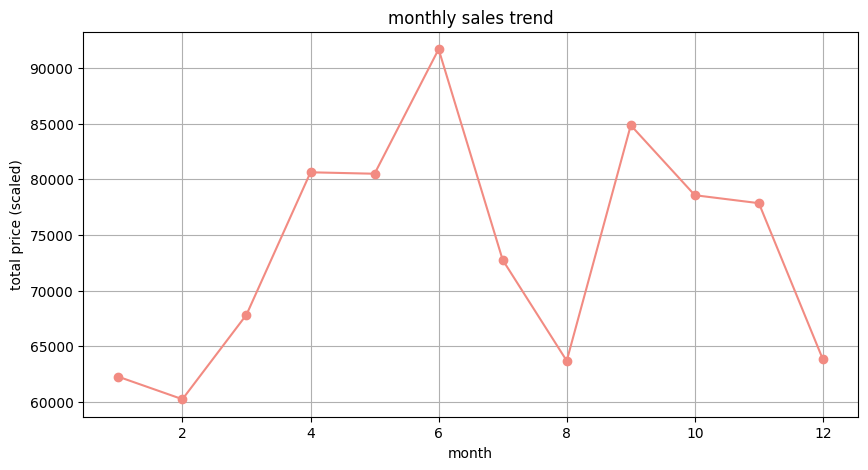

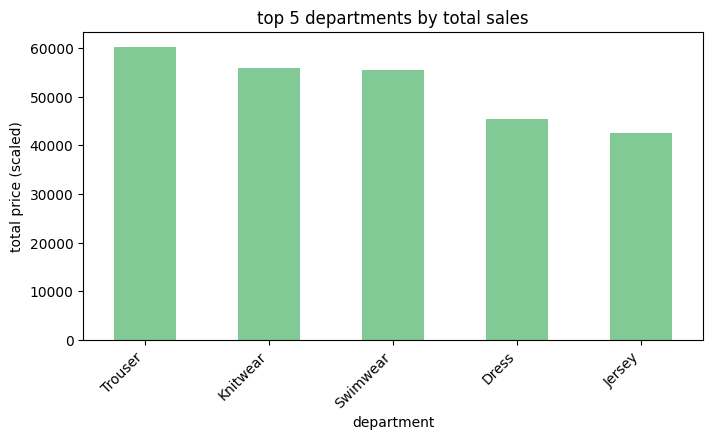

In [10]:
# checking which product types made the most money
top_products = (
    full_data.groupby("product_type_name")["price"]
    .sum()
    .compute()           # computing only the small grouped result
    .nlargest(10)
)

# plotting top 10 product types
plt.figure(figsize=(10,5))
top_products.plot(kind="bar", color="#90CAF9")
plt.title("top 10 product types by total sales")
plt.xlabel("product type")
plt.ylabel("total price (scaled)")
plt.xticks(rotation=45, ha="right")
plt.show()


# checking how total sales changed month by month
monthly_sales = (
    full_data.groupby("month")["price"]
    .sum()
    .compute()           # compute only the aggregated month-level data
    .sort_index()
)

# plotting monthly sales trend
plt.figure(figsize=(10,5))
monthly_sales.plot(kind="line", marker="o", color="#F28B82")
plt.title("monthly sales trend")
plt.xlabel("month")
plt.ylabel("total price (scaled)")
plt.grid(True)
plt.show()


# checking which departments made the most sales
dept_sales = (
    full_data.groupby("department_name")["price"]
    .sum()
    .compute()           # compute after grouping, not before
    .nlargest(5)
)

# bar chart for top 5 departments
plt.figure(figsize=(8,4))
dept_sales.plot(kind="bar", color="#81C995")
plt.title("top 5 departments by total sales")
plt.xlabel("department")
plt.ylabel("total price (scaled)")
plt.xticks(rotation=45, ha="right")
plt.show()


#### Insights:
**Top 10 product types by sales:**
- trousers, dresses & sweaters bring in the highest total sales.
- bottom-wear and full-body outfits dominate overall revenue.

**Monthly sales trend:**
- sales peak around June (month 6) and again in September.
- lowest in Feb & Dec — likely off-season months.

**Top 5 departments by sales:**
- trouser, knitwear & swimwear are top-earning departments.
- dress & jersey follow closely, showing consistent demand.

### Analytics 3: Age Group and Product Preference
The final analysis examined how product preferences differ across age groups. Customers were divided into six age categories: <20, 20–30, 30–40, 40–50, 50–60, and 60+. Total spending for each product type within each group was calculated.
- Across all age groups, trousers, dresses, and sweaters remained the top three product types.
- The 20–30 age group recorded the highest total spending, confirming it as H&M’s primary target audience.
- Younger and older age groups purchased similar product categories but with smaller total spending amounts.

This analysis used .sum().compute() to aggregate the full dataset efficiently, and the resulting summary highlighted the consistency of product preferences across age ranges.

In [11]:

def age_group_label(age):
    if age < 20:
        return "<20"
    elif age < 30:
        return "20-30"
    elif age < 40:
        return "30-40"
    elif age < 50:
        return "40-50"
    elif age < 60:
        return "50-60"
    else:
        return "60+"

# applying this function to create an age_group column
full_data["age_group"] = full_data["age"].map(age_group_label, meta=("age", "object"))

# checking which product types each age group spends the most on
age_product_sales = (
    full_data.groupby(["age_group", "product_type_name"])["price"]
    .sum()
    .compute()
    .reset_index()
)

# picking top 3 product types for each age group
top_products_by_age = (
    age_product_sales.sort_values(["age_group", "price"], ascending=[True, False])
    .groupby("age_group")
    .head(3)
)

# showing result
top_products_by_age


,age_group,product_type_name,price
18,20-30,Trousers,56347.947237
369,20-30,Dress,45618.053814
382,20-30,Sweater,30953.216983
666,30-40,Trousers,30047.545390
513,30-40,Dress,25562.939746
273,30-40,Sweater,15165.002576
413,40-50,Trousers,24849.529864
536,40-50,Dress,18182.576271
296,40-50,Sweater,12503.329831
563,50-60,Trousers,27943.943610


#### Insights:
Across all age groups, trousers, dresses, and sweaters are the top three products.
- 20–30 age group spends the most overall
- 30–50 shows steady buying across the same product types.

Overall pattern shows H&M’s core sales come from everyday essentials rather than niche categories.

